In [1]:
"""
Inter-Chain C-C, C-G, and G-G Contact Analysis Script for Submission

Author: Qin Zhang
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script analyzes inter-chain C-C, C-G, and G-G contacts in RNA systems under varying salt concentrations.
"""
# %% Cell 1: Data Configuration and Analysis
import MDAnalysis as mda
import numpy as np
import pickle
import matplotlib.pyplot as plt
from MDAnalysis.analysis import distances
import os
from tqdm import tqdm
"""
Define file paths for RNA systems (3xG4C2 and 5xG4C2) under different salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x ={
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
"""
Define chain index ranges for 5xG4C2 system.
Each chain is represented as a slice object for atom selection.
"""
chains_5x = {
    "ch1": slice(0, 359),
    "ch2": slice(360, 719),
    "ch3": slice(720, 1079),
    "ch4": slice(1080, 1439),
    "ch5": slice(1440, 1799),
    "ch6": slice(1800, 2159),
    "ch7": slice(2160, 2519),
    "ch8": slice(2520, 2879),
    "ch9": slice(2880, 3239),
    "ch10": slice(3240, 3599),
    "ch11": slice(3600, 3959),
    "ch12": slice(3960, 4319)
}
"""
System configuration dictionary:
- chains: Atom index slices for each RNA chain
- conditions: Paths to simulation data under different salt conditions
- color: Color mapping for contact types in plots
"""
SYSTEMS = {
    '3xG4C2': {
        'chains': {f"ch{i}": slice(i*216, (i+1)*216) for i in range(12)}, 
        'conditions': conditions_3x,
        'color': {'CC': '#1f77b4', 'CG': '#ff7f0e', 'GG': '#2ca02c'}
    },
    '5xG4C2': {
        'chains': chains_5x,
        'conditions': conditions_5x,
        'color': {'CC': '#aec7e8', 'CG': '#ffbb78', 'GG': '#98df8a'}
    }
}
SALT_CONCENTRATIONS = [0, 17, 35, 70, 139, 278, 487, 696]  # mM NaCl
REPLICAS = ['C1', 'C2', 'C3', 'C4']  # Simulation replicas
CONTACT_TYPES = ['CC', 'CG', 'GG']  # Contact types (C-C, C-G, G-G)

def analyze_system(system_config, condition_path, cond_name, verbose=False):
    """
    Analyze inter-chain contacts for a specific system and salt condition.
    
    Parameters:
        system_config (dict): System configuration (chains, colors, etc.)
        condition_path (str): Path to simulation data for the condition
        cond_name (str): Condition name (e.g., '487mMNaCl')
        verbose (bool): If True, print detailed analysis progress
        
    Returns:
        dict: Global mean and standard deviation of inter-chain contacts
    """
    all_replica_means = {ct: [] for ct in CONTACT_TYPES}
    
    for replica in REPLICAS:
        gro_path = os.path.join(condition_path, replica, "RNA.gro")
        xtc_path = os.path.join(condition_path, replica, "RNA_clusterRNA.xtc")
        
        if not os.path.exists(gro_path):
            print(f"Warning: {gro_path} not exist，skip{replica}")
            continue
        if not os.path.exists(xtc_path):
            print(f"Warning: {xtc_path} not exist，skip{replica}")
            continue
            
        u = mda.Universe(gro_path, xtc_path)
        replica_results = {ct: [] for ct in CONTACT_TYPES}

        # Prepare chain data with C and G residue selections
        chains = {}
        for chain_name, slc in system_config['chains'].items():
            chain = u.atoms[slc]
            C = chain.select_atoms("resname RC and name SC3")
            G = chain.select_atoms("resname RG and name SC3")
            chains[chain_name] = {"C": C, "G": G}

        # Log total atom counts for debugging
        total_c = sum(len(chain["C"]) for chain in chains.values())
        total_g = sum(len(chain["G"]) for chain in chains.values())
        if verbose:
            print(f"\nInformation - {cond_name} {replica}: Total number of C atoms={total_c}, Total number of G atoms={total_g}")
       
        # Analyze every 50th frame for efficiency
        n_frames = len(u.trajectory[::50])
        if n_frames == 0:
            print(f"Error: {xtc_path} has no valid frames")
            continue

        for ts in u.trajectory[::50]: 
            contact_counts = {"CC": 0, "CG": 0, "GG": 0} 
            # Calculate inter-chain contacts
            chain_list = list(chains.values())
            for i in range(len(chain_list)):
                for j in range(i+1, len(chain_list)):
                    # # C-C contacts between different chains
                    ci = chain_list[i]["C"].positions
                    cj = chain_list[j]["C"].positions
                    if len(ci)*len(cj) > 0:
                        dist = distances.distance_array(ci, cj, box=ts.dimensions)
                        contact_counts["CC"] += np.sum(dist < 6) ## please change dist < 9 to have figure3a in manuscript
                    
                    # # C-G contacts between different chains
                    ci = chain_list[i]["C"].positions
                    gj = chain_list[j]["G"].positions
                    if len(ci)*len(gj) > 0:
                        dist = distances.distance_array(ci, gj, box=ts.dimensions)
                        contact_counts["CG"] += np.sum(dist < 6) ## please change dist < 9 to have figure3a in manuscript
                    
                    # # G-G contacts between different chains
                    gi = chain_list[i]["G"].positions
                    gj = chain_list[j]["G"].positions
                    if len(gi)*len(gj) > 0:
                        dist = distances.distance_array(gi, gj, box=ts.dimensions)
                        contact_counts["GG"] += np.sum(dist < 6) ## please change dist < 9 to have figure3a in manuscript

            # Log first frame as example
            if verbose and ts.frame == 0: 
                print(f"First frame contact count example: CC={contact_counts['CC']}, CG={contact_counts['CG']}, GG={contact_counts['GG']}")

            # Store contact counts for this frame
            for ct in CONTACT_TYPES:
                replica_results[ct].append(contact_counts[ct])

        # Calculate and store replica mean
        for ct in CONTACT_TYPES:
            if len(replica_results[ct]) == 0:
                print(f"Error: {cond_name} {replica} {ct} has no valid data")
                continue
            replica_mean = np.mean(replica_results[ct])
            all_replica_means[ct].append(replica_mean)
            if verbose:
                print(f"{cond_name} {replica} {ct} mean: {replica_mean:.1f} (based on {n_frames} frames)")

     # Calculate global statistics
    stats = {}
    for ct in CONTACT_TYPES:
        replica_means = all_replica_means[ct]
        if len(replica_means) == 0:
            print(f"Error: {cond_name} {ct} has no valid replica data")
            stats[ct] = (0, 0)
            continue
            
        global_mean = np.mean(replica_means)
        sd = np.std(replica_means, ddof=1) if len(replica_means) > 1 else 0
        
        if verbose:
            print(f"\nStatistics - {cond_name} {ct}:")
            print(f"Valid replicas: {len(replica_means)}")
            print(f"Replica means: {[round(m,1) for m in replica_means]}")
            print(f"Global mean: {global_mean:.1f} ± {sd:.1f}")

        stats[ct] = (global_mean, sd)
    
    return stats

# Execute analysis for all systems and conditions
full_results = {}
for system_name in SYSTEMS:
    full_results[system_name] = {}
    for cond_name, cond_path in SYSTEMS[system_name]['conditions'].items():
        salt = int(cond_name.replace('mMNaCl', '')) if 'mMNaCl' in cond_name else 0
        full_results[system_name][salt] = analyze_system(
            SYSTEMS[system_name], 
            cond_path,
            cond_name=cond_name, 
            verbose=True
        )

# Save results for future use
with open('3x5_inter_CCCGG_contacts.pkl', 'wb') as f:
    pickle.dump(full_results, f)



Information - neutral C1: Total number of C atoms=72, Total number of G atoms=144
First frame contact count example: CC=3, CG=11, GG=23
neutral C1 CC mean: 3.3 (based on 201 frames)
neutral C1 CG mean: 10.0 (based on 201 frames)
neutral C1 GG mean: 21.5 (based on 201 frames)

Information - neutral C2: Total number of C atoms=72, Total number of G atoms=144
First frame contact count example: CC=4, CG=19, GG=26
neutral C2 CC mean: 4.0 (based on 201 frames)
neutral C2 CG mean: 19.6 (based on 201 frames)
neutral C2 GG mean: 26.9 (based on 201 frames)

Information - neutral C3: Total number of C atoms=72, Total number of G atoms=144
First frame contact count example: CC=8, CG=8, GG=31
neutral C3 CC mean: 9.3 (based on 201 frames)
neutral C3 CG mean: 8.5 (based on 201 frames)
neutral C3 GG mean: 29.2 (based on 201 frames)

Information - neutral C4: Total number of C atoms=72, Total number of G atoms=144
First frame contact count example: CC=1, CG=8, GG=26
neutral C4 CC mean: 1.9 (based on 2

In [2]:
# %% Cell 2: Data Loading and Preparation
import pickle
import numpy as np

# Load precomputed inter-chain contact results
with open('3x5_inter_CCCGG_contacts.pkl', 'rb') as f:
    full_results = pickle.load(f)

# Define parameters for plotting
salt_order = [0, 17, 35, 70, 139, 278, 487, 696]
systems = ['3xG4C2', '5xG4C2']
ctypes = ['CC', 'CG', 'GG']

# Organize data into numpy array: [salt, system, ctype, (mean, err)]
plot_data = np.zeros((len(salt_order), len(systems), len(ctypes), 2))
for i, salt in enumerate(salt_order):
    for j, sys in enumerate(systems):
        for k, ct in enumerate(ctypes):
            plot_data[i,j,k] = full_results[sys][salt][ct]


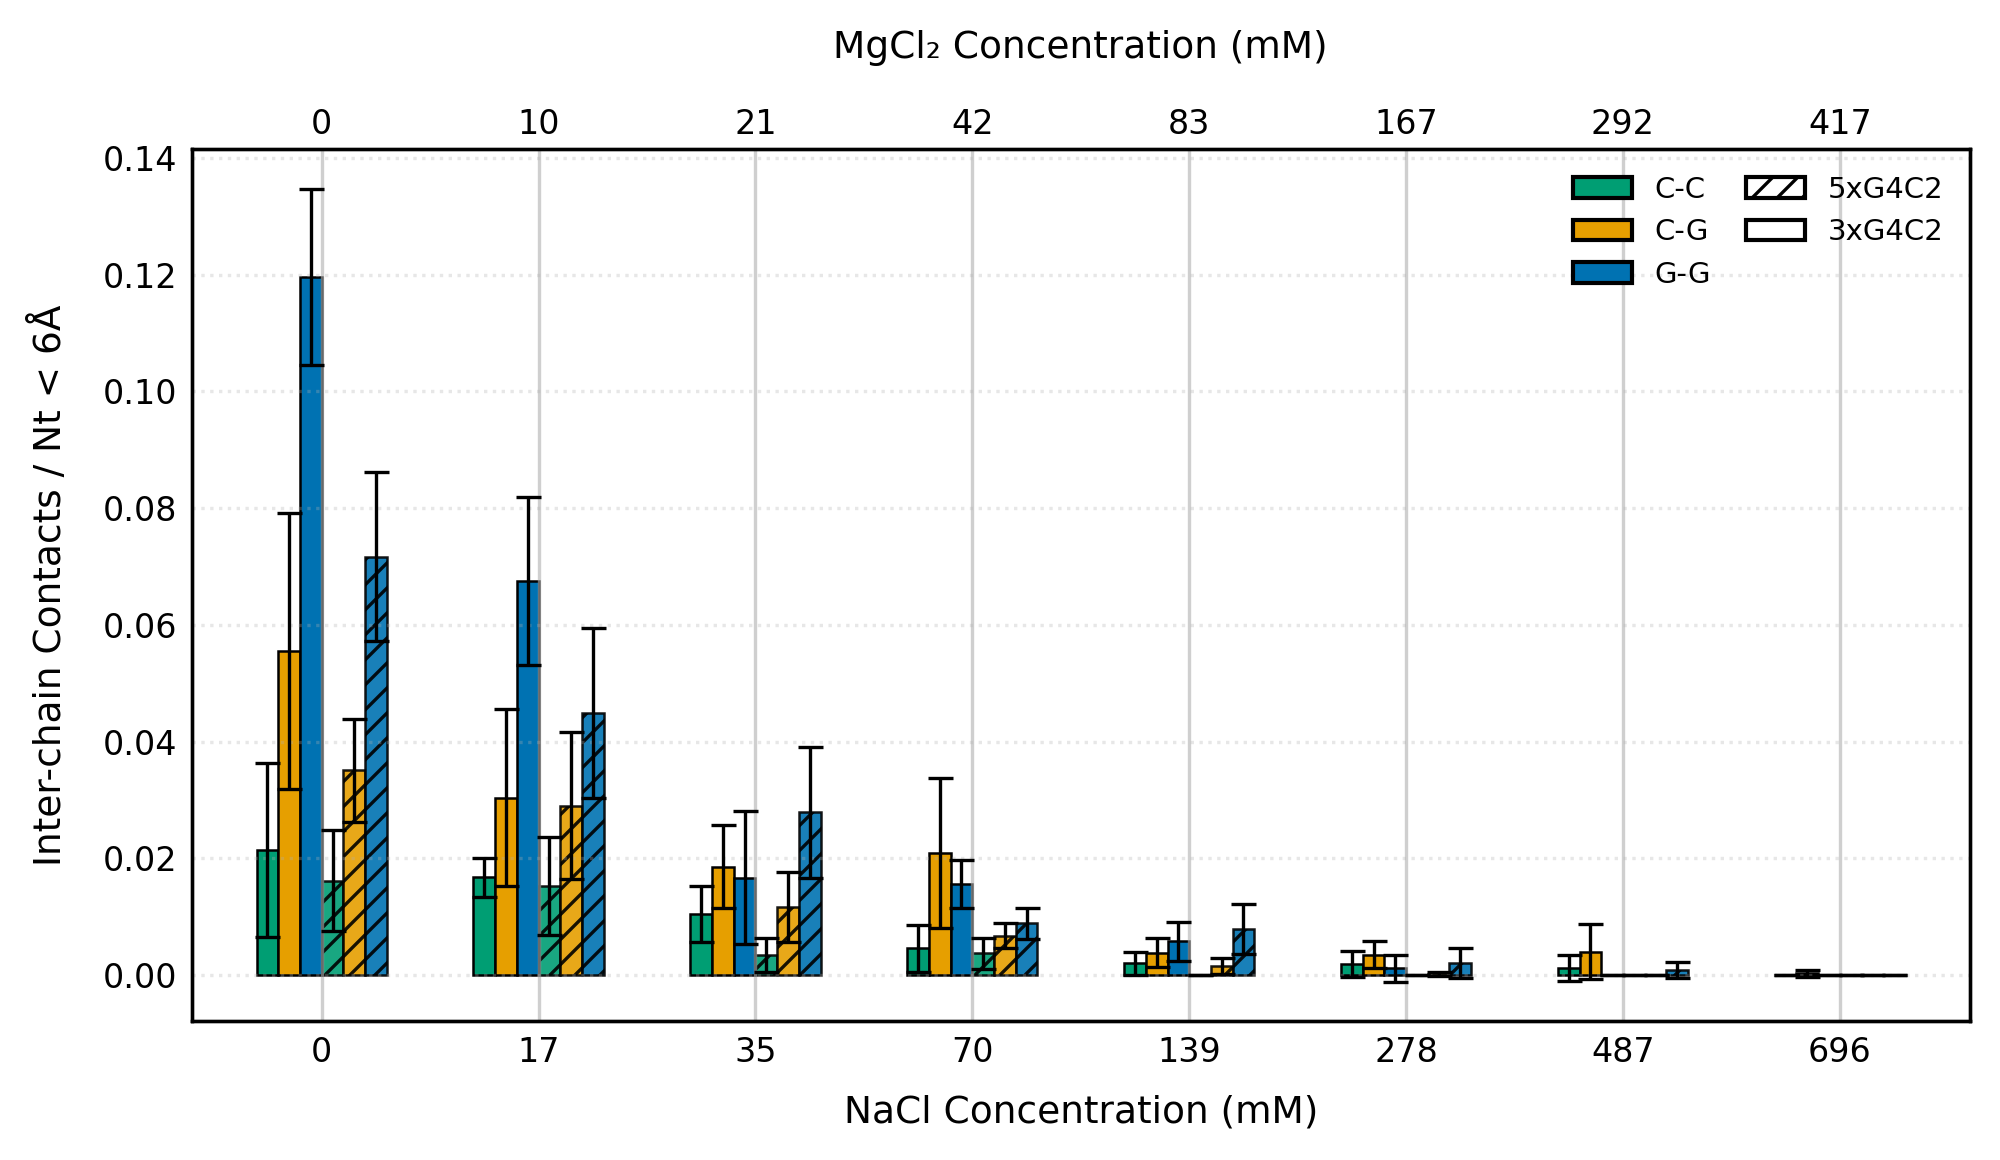

In [5]:
# %% Cell 4: Normalized Contact Plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
# Maintain consistent plot style
rcParams.update({
    'font.sans-serif': 'DejaVu Sans',
    'font.size': 8,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'legend.fontsize': 7,
    'figure.dpi': 300,
    'figure.figsize': (6.8, 4.0),
    'savefig.dpi': 300,
    'hatch.linewidth': 0.8
})

COLOR_MAP = {
    'CC': '#009E73',
    'CG': '#E69F00',
    'GG': '#0072B2'
}

fig, ax = plt.subplots()

nacl_ticks = np.array([0, 17, 35, 70, 139, 278, 487, 696])
mgcl2_ticks = np.array([0, 10, 21, 42, 83, 167, 292, 417])
x_pos = np.arange(len(nacl_ticks))
bar_width = 0.1 

offset_dict = {
    '3xCC': -bar_width*2.5,
    '3xCG': -bar_width*1.5,
    '3xGG': -bar_width*0.5,
    '5xCC': bar_width*0.5,
    '5xCG': bar_width*1.5,
    '5xGG': bar_width*2.5
}
# Normalize contacts by total number of nucleotides
chain_lengths = {
    '3xG4C2': 18*12,  # 18 nt per chain, 12 chains
    '5xG4C2': 30*12   # 30 nt per chain, 12 chains
}

norm1_data = np.zeros_like(plot_data)
for i in range(len(salt_order)):
    for j, sys in enumerate(['3xG4C2', '5xG4C2']):
        clen = chain_lengths[sys]
        for k in range(len(ctypes)):
            norm1_data[i,j,k,0] = plot_data[i,j,k,0] / clen
            norm1_data[i,j,k,1] = plot_data[i,j,k,1] / clen  # Propagate error

# Plot normalized data
for sidx in range(len(nacl_ticks)):
    # 3xG4C2 system
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(norm1_data[sidx, 0, i, 0]):
            continue
        offset = list(offset_dict.values())[i]
        mean, err = norm1_data[sidx, 0, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})

    # 5x system
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(norm1_data[sidx, 1, i, 0]):
            continue
        offset = list(offset_dict.values())[i+3]
        mean, err = norm1_data[sidx, 1, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
               hatch='////', alpha=0.9,
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})

# Configure axes (similar to previous plot)
ax.set_xlabel('NaCl Concentration (mM)', labelpad=6)
ax.set_xlim(-0.6, len(nacl_ticks)-0.4)
ax.set_xticks(x_pos)
ax.set_xticklabels(nacl_ticks, rotation=0, ha='center')
ax.tick_params(axis='x', length=0, bottom=False)

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x_pos)
ax_top.set_xticklabels(mgcl2_ticks, rotation=0, ha='center', va='bottom')
ax_top.set_xlabel('MgCl₂ Concentration (mM)', labelpad=12)
ax_top.tick_params(axis='x', length=0, pad=2)

ax.set_ylabel('Inter-chain Contacts / Nt < 6Å', labelpad=8)
ax.tick_params(axis='both', which='major', length=0, width=0.8)

# Reuse legend from previous plot
legend_elements = [
    Patch(facecolor=COLOR_MAP['CC'], edgecolor='k', label='C-C'),
    Patch(facecolor=COLOR_MAP['CG'], edgecolor='k', label='C-G'),
    Patch(facecolor=COLOR_MAP['GG'], edgecolor='k', label='G-G'),
    Patch(facecolor='white', edgecolor='k', hatch='////', label='5xG4C2'),
    Patch(facecolor='white', edgecolor='k', label='3xG4C2')
]

ax.legend(handles=legend_elements, 
         loc='upper right', 
         ncol=2,
         frameon=False,
         handletextpad=0.8,
         columnspacing=1.2)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.6)
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.3)

plt.tight_layout(pad=1.5)
plt.savefig('figure3a_figS4a.png', dpi=300, bbox_inches='tight')
plt.show()